# CNN-Based Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we investigate a new **self-supervised deep learning approach** for peak fitting in synthetic XRD-CT datasets, and compare it to a conventional parameter-based fitting workflow. Both approaches are applied to a phantom dataset generated using the `nDTomo` package, simulating realistic peak shapes and background contributions under Poisson noise.

Peak fitting remains a critical step in XRD-CT analysis, enabling the extraction of quantitative parameters such as phase content, strain, and crystallite size. However, traditional voxel-by-voxel fitting methods can be slow, sensitive to noise, and difficult to scale. Here, we test whether a CNN trained directly on downsampled spectra can learn to infer accurate and denoised peak parameter maps.

## 🎯 Objectives

By the end of this notebook, you will:
- Generate a synthetic 3D XRD-CT dataset with spatially varying Gaussian peaks and linear background
- Add realistic Poisson noise to simulate photon-limited experiments
- Fit the data using two approaches:
  - Conventional parameter map-based fitting
  - **PeakFitCNN**: a self-supervised CNN that infers peak parameters from downsampled input
- Evaluate and compare the accuracy and noise robustness of both methods

## 🤖 What is PeakFitCNN?

PeakFitCNN is a **self-supervised convolutional neural network** designed to learn peak parameters from hyperspectral XRD-CT data **without needing ground truth labels**. It works by:
- Receiving a 4× downsampled hyperspectral input volume
- Predicting full-resolution parameter maps (amplitude, position, width, background slope and intercept)
- Reconstructing the spectra using a differentiable peak model
- Optimizing only through the reconstruction error

This approach naturally combines **denoising**, **super-resolution**, and **peak decomposition**, while avoiding the instability of pixel-wise nonlinear curve fitting.

## 📦 Dataset

We will use a synthetic dataset constructed as follows:
- Each voxel contains a **single Gaussian peak** with a linear background
- The five peak parameters vary smoothly across the field of view
- The diffraction axis is sampled over:

$$
(x, y, q) = (240, 240, 50)
$$

where $q$ represents the diffraction domain (e.g., $2\theta$).

Poisson noise is added to approximate photon-counting uncertainty, mimicking experimental conditions.

We now begin by importing the required modules and generating the simulated dataset.

## 🏗️ Generate Synthetic Spatial Maps

We begin by generating five synthetic 2D spatial images using the `nDTomophantom_2D()` function. Each image (`im1` to `im5`) will later be used to define a different peak or background parameter (e.g., peak position, width, amplitude, background slope/intercept) across the field of view.

These phantoms serve as parameter maps with smoothly varying features, simulating different chemical or structural domains in a realistic XRD-CT sample.

We also normalize `im5` so that it scales between 0 and 1, which is useful for defining background offset values. Finally, the spatial maps are visualized using `showim()` to verify the underlying structures.

c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorith

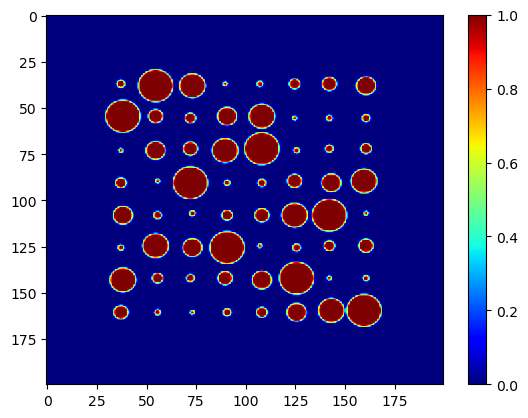

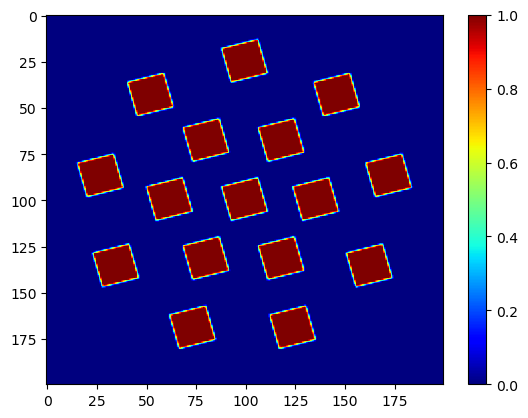

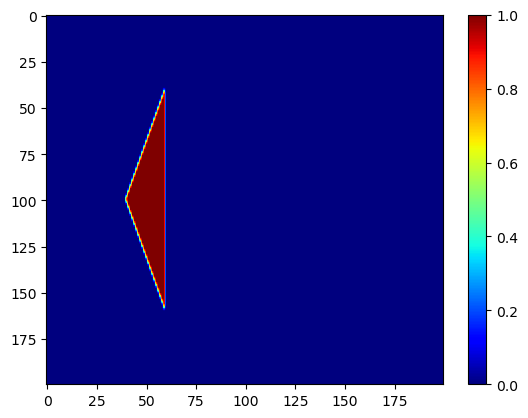

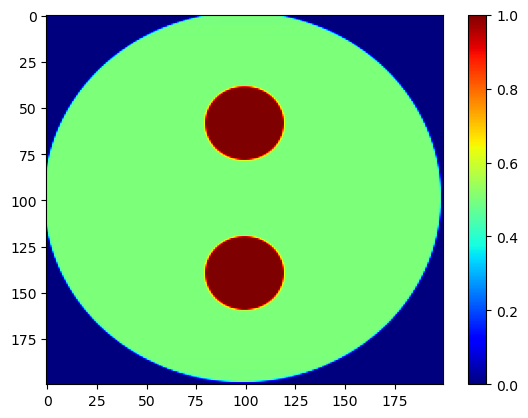

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim


# Create 2D spatial images for the five components
npix = 200
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)


## 🧪 Simulate Hyperspectral Volume with Spatially Varying Peak Parameters

We now define the **analytical peak model** used to generate our synthetic dataset. Each voxel in the volume will contain a spectrum consisting of a **single Gaussian peak** with a **linear background**.

Two functions are defined:
- `gaussian(x, A, mu, sigma)` – generates a peak given amplitude, center, and width
- `linear_background(x, slope, intercept)` – models a linear baseline across the diffraction axis

We then:
1. Define the diffraction axis `x`, sampled between 0 and 5 with a step size of 0.1
2. Specify the valid parameter ranges for all five quantities:
   - **Peak amplitude** (A): varies with `im2 + im5`
   - **Peak position** (μ): varies with `im2`
   - **Peak width** (σ): varies with `im3`
   - **Background slope**: varies with `im4`
   - **Background intercept**: varies with `im5`

The resulting 2D hyperspectral image `vol` is populated voxel-by-voxel, only in regions with non-negligible peak amplitude (`mask_tmp > 0`).

We then pad the hyperspectral image spatially by 20 pixels on each side to ensure compatibility with CNN architectures that may expect padding or stride-sensitive dimensions.

Finally, we simulate **Poisson noise** using the `addpnoise3D()` function, which mimics photon-counting statistics typically observed in synchrotron X-ray imaging. The noise level is controlled by a `ct` value (e.g. 100 = moderate photon count). The resulting noisy synthetic dataset will be used for both conventional and CNN-based fitting.

In [2]:

def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
# x = np.arange(0, 5, 0.025)
# x = np.arange(0, 5, 0.075)
x = np.arange(0, 5, 0.1)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 20
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))


def addpnoise3D(vol, ct):
    '''
    Adds Poisson noise to a 3D hyperspectral volume (H x W x Bands),
    noise is added per pixel-spectrum (i.e., per (i,j,:)).
    
    Parameters
    ----------
    vol : ndarray
        3D hyperspectral image (H x W x Bands), must be non-negative.
    ct : float
        Scaling constant to simulate photon counts.
    '''
    vol = vol.copy()
    mi = np.min(vol)
    if mi < 0:
        vol = vol - mi + np.finfo(np.float32).eps
    elif mi == 0:
        vol = vol + np.finfo(np.float32).eps

    # Apply Poisson noise per pixel-spectrum
    noisy = np.random.poisson(vol * ct) / ct
    return noisy

# vol = vol + 0.001*np.random.rand(vol.shape[0], vol.shape[1], vol.shape[2])
# # vol = addpnoise3D(vol, ct=1000)
vol = addpnoise3D(vol, ct=100)
vol[vol<0] = 0



100%|██████████| 200/200 [00:00<00:00, 539.52it/s]


(240, 240, 50) 1.5


We can now interactively explore the spectral content of this volume using the chemimexplorer

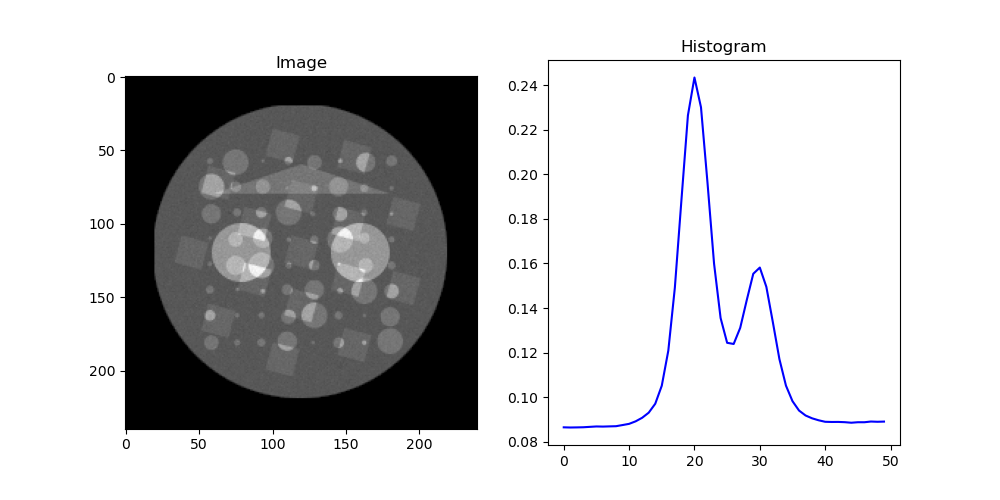

In [3]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(vol)

In [ ]:
import torch, time
import torch.nn.functional as F
from torch.quasirandom import SobolEngine
from torch import nn
from peakcnn.utils import calc_patches_indices, denormalize


def create_cirmask(npix_im=512, npx=0):

    """
    Create a circular mask for a squared image.

    Args:
        npix_im (int): Size of the squared image (default: 512).
        npx (int): Number of pixels to exclude from the circular mask (default: 0).
    
    Returns:
        numpy.ndarray: A binary circular mask with excluded pixels.
    """
    im = np.ones((npix_im, npix_im), dtype='float32')
    sz = np.floor(im.shape[0])
    x = np.arange(0,sz)
    x = np.tile(x,(int(sz),1))
    y = np.swapaxes(x,0,1)
    xc = np.round(sz/2)
    yc = np.round(sz/2)
    r = np.sqrt(((x-xc)**2 + (y-yc)**2))
    im = np.where(r>np.floor(sz/2) - npx,0,1)
    return(im)

def denormalize(param, param_name, param_min, param_max, peak_number=None):

    """
    Denormalize the parameter from [0, 1] to its original range.
    
    Parameters:
    param (float): The parameter to be denormalized.
    param_name (str): The name of the parameter.
    param_min (dict): A dictionary containing the minimum values of the parameters.
    param_max (dict): A dictionary containing the maximum values of the parameters.
    peak_number (int, optional): The peak number for the parameter. Default is None.
    
    Returns:
    float: The denormalized parameter.
    """
        
    if peak_number is None:  # For Slope and Intercept
        return param_min[param_name] + (param_max[param_name] - param_min[param_name]) * param
    return param_min[param_name][peak_number] + (param_max[param_name][peak_number] - param_min[param_name][peak_number]) * param


def calc_indices(npix_x, npix_y, num_patches, patch_size=32):

    """
    Calculate the indices of the patches to be selected.

    Parameters:
    npix_x (int): The number of pixels in the x direction.
    npix_y (int): The number of pixels in the y direction.
    num_patches (int): The number of patches to be selected.
    patch_size (int, optional): The size of the patches. Default is 32.

    Returns:
    list: A list of tuples containing the starting indices of the selected patches.
    """
        
    selected_indices = []  # Store the indices of selected patches
    # Randomly select patches
    for _ in range(num_patches):
        h_start = torch.randint(0, npix_x - patch_size + 1, size=(1,))
        w_start = torch.randint(0, npix_y - patch_size + 1, size=(1,))
        # Store the starting indices of each patch
        selected_indices.append((h_start.item(), w_start.item()))
    return(selected_indices)
    

def calc_patches_indices(indices, tensor, patch_size, use_middle=False):
    """
    Calculate the indices of the patches to be selected based on the provided indices.
    Users can choose to use the middle of the patch or the top-left as the reference point.
    
    Parameters:
    indices (list of tuples): A list of tuples containing the starting indices of the patches.
    tensor (torch.Tensor): The tensor from which the patches are to be selected.
    patch_size (int): The size of the patches.
    use_middle (bool): If True, use the middle pixel as the reference. If False, use the top-left.
    
    Returns:
    torch.Tensor: A tensor containing the selected patches.
    """
    selected_patches = []
    if use_middle:
        half_patch = int(patch_size / 2)
        for (h_start, w_start) in indices:
            h_center = h_start - half_patch
            w_center = w_start - half_patch
            patch = tensor[..., h_center:h_center + patch_size, w_center:w_center + patch_size]
            selected_patches.append(patch)
    else:
        for (h_start, w_start) in indices:
            patch = tensor[..., h_start:h_start + patch_size, w_start:w_start + patch_size]
            selected_patches.append(patch)

    # Concatenate patches for processing
    return torch.cat(selected_patches, dim=0)


def generate_sobol_indices_batch(rows, cols, batch_size, patch_size, device):
    """
    Generate a batch of Sobol indices for a given dimension and batch size, considering the patch size to avoid boundary issues.
    
    Parameters:
    rows (int): The total number of rows in the dataset.
    cols (int): The total number of columns in the dataset.
    batch_size (int): The number of indices to generate.
    patch_size (int): The size of the patch to consider for boundary adjustment.
    device (torch.device): The device to use for generating indices.
    
    Returns:
    tuple: Two tensors containing the row indices and column indices.
    """
    sobol = SobolEngine(dimension=2, scramble=True)

    # Define the range for indices to avoid boundary issues
    max_row = rows - patch_size
    max_col = cols - patch_size

    # Generate indices on the CPU
    points = sobol.draw(batch_size)
    
    # Move the generated points to the specified device and scale them
    points = points.to(device) * torch.tensor([max_row, max_col], device=device, dtype=torch.float32)
    points = points.int()

    return points[:, 0], points[:, 1]


def generate_indices(rows, cols, num_indices, patch_size, distribution_type='uniform', std=3, mask=None, device='cuda', batched=False):
    mean_row = float(rows) / 2
    mean_col = float(cols) / 2
    indices = []
    
    while len(indices) < num_indices:
        batch_size = num_indices - len(indices) if batched else 1

        if distribution_type == 'normal':
            sample_rows = torch.normal(mean=torch.full((batch_size,), mean_row, dtype=torch.float32, device=device),
                                       std=torch.full((batch_size,), std, dtype=torch.float32, device=device)).round().int()
            sample_cols = torch.normal(mean=torch.full((batch_size,), mean_col, dtype=torch.float32, device=device),
                                       std=torch.full((batch_size,), std, dtype=torch.float32, device=device)).round().int()
        elif distribution_type == 'uniform':
            sample_rows = torch.randint(0, rows, (batch_size,), device=device)
            sample_cols = torch.randint(0, cols, (batch_size,), device=device)
        elif distribution_type == 'Sobol':
            sample_rows, sample_cols = generate_sobol_indices_batch(rows, cols, batch_size, patch_size, device)
        else:
            raise ValueError("Invalid distribution type specified. Choose 'normal', 'uniform', or 'Sobol'.")

        sample_rows = sample_rows.long()  # Ensure indices are long for masking
        sample_cols = sample_cols.long()

        # Validate indices within range
        valid = (sample_rows >= 0) & (sample_rows < rows) & (sample_cols >= 0) & (sample_cols < cols)

        # Apply mask if available and ensure indices are used for mask access are already validated
        if mask is not None and valid.any():
            valid_indices = valid.nonzero(as_tuple=True)
            valid_mask = mask[sample_rows[valid_indices], sample_cols[valid_indices]]
            # Refine valid to include only those indices where mask is true
            valid[valid_indices] = valid_mask

        # Collect valid indices
        valid_sample_rows = sample_rows[valid]
        valid_sample_cols = sample_cols[valid]

        indices.extend(zip(valid_sample_rows.tolist(), valid_sample_cols.tolist()))
        if len(indices) >= num_indices:
            indices = indices[:num_indices]  # Ensure we do not exceed the number of requested indices

    return indices


def initialize_counter(rows, cols):
    """
    Initialize a zero-filled counter matrix of the same size as the input matrix using PyTorch.
    
    Parameters:
    - matrix (2D torch tensor): Matrix whose dimensions will be used to create the counter.
    
    Returns:
    - 2D torch tensor: Initialized counter matrix.
    """
    return torch.zeros((rows, cols), dtype=torch.float32)

def update_counter(counter, indices, patch_size=(1, 1)):
    """
    Update the pixel utilization counter based on the middle indices of extracted patches or pixels using PyTorch.
    
    Parameters:
    - counter (2D torch tensor): Counter matrix to be updated.
    - indices (list of tuples): Indices of the top-left corners of the patches or pixels.
    - patch_size (tuple): Size (height, width) of the patches or single pixel (default is 1x1 for pixels).
    """
    patch_rows, patch_cols = patch_size
    for r, c in indices:
        # counter[r - int(patch_rows/2):r + int(patch_rows/2), c - int(patch_cols/2):c + int(patch_cols/2)] += 1
        counter[r:r + int(patch_rows), c :c + int(patch_cols)] += 1


def sample_and_count(rows, cols, num_indices, num_iterations, patch_size, distribution_type,
                     batched=False, std_dev=None, mask=None, device='cuda'):
    """
    Repeatedly sample indices, update the utilization counter for patches or single pixels for a specified number of iterations.
    
    Parameters:
    - rows (int): The rows of the matrix.
    - cols (int): The columns of the matrix.
    - num_indices (int): Number of indices per iteration.
    - num_iterations (int): Number of sampling iterations.
    - patch_size (int): Size of each patch (square) if use_patches is True, otherwise 1 for single pixels.
    - distribution_type (str): 'normal' or 'uniform' for distribution type.
    - use_gpu (bool): Flag to use GPU if available.
    - use_patches (bool): Flag to decide between using patches or single pixels.
    
    Returns:
    - 2D torch tensor: Counter matrix showing pixel utilization.
    """
    counter = initialize_counter(rows, cols)
    patch_dimensions = (patch_size, patch_size)

    for _ in range(num_iterations):
        indices = draw_valid_indices(rows, cols, num_indices, patch_size, distribution_type, batched,
                                     std_dev=std_dev, mask=mask, device=device)      
        update_counter(counter, indices, patch_dimensions)

    return counter

def draw_valid_indices(rows, cols, num_indices, patch_size, distribution_type='normal', 
                       batched=False, std_dev=3, mask=None, device='cuda'):

    """
    Draw valid indices from a specified distribution.
    
    Parameters:
    rows (int): The total number of rows.
    cols (int): The total number of columns.
    num_indices (int): The number of indices to draw.
    patch_size (int): The size of the square patch.
    distribution_type (str): The type of distribution to draw from ('normal', 'uniform' or 'Sobol').
    std_dev (float): The standard deviation for the normal distribution.
    mask (torch.Tensor): A mask to apply to the indices.
    device (torch.device): The device on which to generate the indices.
    
    Returns:
    list: A list of valid indices.
    """
    
    if distribution_type == 'normal' and std_dev is None:
        largest_dimension = max(rows, cols)
        std_dev = largest_dimension / 3  # 3 sigma to span the largest dimension
    indices = generate_indices(rows, cols, num_indices, patch_size, distribution_type=distribution_type, 
                               std=std_dev, mask=mask, device=device, batched=batched)
    return indices


def generate_indices_rmse_map(global_rmse_map, rows, cols, num_indices, patch_size, mask=None, device='cuda', batched=True, method='highest'):
    indices = []
    while len(indices) < num_indices:
        batch_size = num_indices - len(indices) if batched else 1

        if global_rmse_map is not None:
            if method == 'stochastic':
                # Stochastic sampling based on normalized RMSE values
                weights = global_rmse_map.flatten()
                weights = (weights - weights.min()) / (weights.max() - weights.min())
                indices_flat = torch.multinomial(weights, batch_size, replacement=True)
            elif method == 'highest':
                # Deterministic selection based on highest RMSE values
                flat_rmse_map = global_rmse_map.flatten()
                _, sorted_indices = torch.sort(flat_rmse_map, descending=True)
                indices_flat = sorted_indices[:batch_size]  # Take top batch_size indices

            sample_rows = (indices_flat // cols).clamp(min=patch_size // 2, max=rows - patch_size // 2 - 1)
            sample_cols = (indices_flat % cols).clamp(min=patch_size // 2, max=cols - patch_size // 2 - 1)
        else:
            # Fallback if no RMSE map is provided: random sampling
            sample_rows = torch.randint(patch_size // 2, rows - patch_size // 2, (batch_size,), device=device)
            sample_cols = torch.randint(patch_size // 2, cols - patch_size // 2, (batch_size,), device=device)

        sample_rows = sample_rows.long()
        sample_cols = sample_cols.long()
        valid = (sample_rows >= patch_size // 2) & (sample_rows < rows - patch_size // 2) & \
                (sample_cols >= patch_size // 2) & (sample_cols < cols - patch_size // 2)

        # Apply mask if available and ensure indices are used for mask access are already validated
        if mask is not None and valid.any():
            valid_indices = valid.nonzero(as_tuple=True)
            valid_mask = mask[sample_rows[valid_indices], sample_cols[valid_indices]]
            # Refine valid to include only those indices where mask is true
            valid[valid_indices] = valid_mask

        # Collect valid indices
        valid_sample_rows = sample_rows[valid]
        valid_sample_cols = sample_cols[valid]
        indices.extend(zip(valid_sample_rows.tolist(), valid_sample_cols.tolist()))
        if len(indices) >= num_indices:
            indices = indices[:num_indices]  # Ensure we do not exceed the number of requested indices

    return indices


def pad_and_filter_patch_indices(tensor, mask, patch_size):
    # Get dimensions of tensor and mask
    h, w, c = tensor.shape
    
    # Calculate necessary padding for height and width
    pad_height = (patch_size - h % patch_size) % patch_size
    pad_width = (patch_size - w % patch_size) % patch_size

    # Pad tensor and mask to make them evenly divisible by patch_size
    padded_tensor = F.pad(tensor, (0, 0, 0, pad_width, 0, pad_height), mode='constant', value=0)
    padded_mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # Generate indices for patches, filtering based on mask
    patch_indices = []
    for i in range(0, padded_tensor.shape[0], patch_size):
        for j in range(0, padded_tensor.shape[1], patch_size):
            mask_patch = padded_mask[i:i + patch_size, j:j + patch_size]
            # Check if the mask patch is all zeros
            if not torch.all(mask_patch == 0):
                patch_indices.append((i, j))

    # Shuffle the indices randomly
    if patch_indices:  # Check if list is not empty
        idx_shuffle = torch.randperm(len(patch_indices))
        patch_indices = [patch_indices[i] for i in idx_shuffle]

    return padded_tensor, patch_indices

def pad_mask(mask, patch_size):
    # Determine the necessary padding for height and width
    h, w = mask.shape
    pad_height = (patch_size - h % patch_size) % patch_size
    pad_width = (patch_size - w % patch_size) % patch_size

    # Pad the mask
    padded_mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)
    return padded_mask

def create_padded_binary_tensor_from_indices(mask, indices, patch_size):
    # Determine the necessary padding for height and width
    h, w = mask.shape
    pad_height = (patch_size - h % patch_size) % patch_size
    pad_width = (patch_size - w % patch_size) % patch_size

    # Pad the mask
    padded_mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)
    padded_mask_shape = padded_mask.shape

    # Create an empty binary tensor of the same size as the padded mask
    binary_tensor = torch.zeros(padded_mask_shape)

    # Set the patches corresponding to the indices to one
    for (start_i, start_j) in indices:
        binary_tensor[start_i:start_i + patch_size, start_j:start_j + patch_size] = 1
    
    return binary_tensor

def filter_patch_indices(mask, patch_size):
    # Generate indices for patches, filtering based on mask
    patch_indices = []
    for i in range(0, mask.shape[0], patch_size):
        for j in range(0, mask.shape[1], patch_size):
            mask_patch = mask[i:i + patch_size, j:j + patch_size]
            # Check if the mask patch is all zeros
            if not torch.all(mask_patch == 0):
                patch_indices.append((i, j))

    # Shuffle the indices randomly
    if patch_indices:  # Check if list is not empty
        idx_shuffle = torch.randperm(len(patch_indices))
        patch_indices = [patch_indices[i] for i in idx_shuffle]

    return patch_indices


def create_binary_tensor_from_indices(mask, indices, patch_size):

    mask_shape = mask.shape

    # Create an empty binary tensor of the same size as the padded mask
    binary_tensor = torch.zeros(mask_shape)

    # Set the patches corresponding to the indices to one
    for (start_i, start_j) in indices:
        binary_tensor[start_i:start_i + patch_size, start_j:start_j + patch_size] = 1
    
    return binary_tensor


## 🎯 Patch Sampling Strategy for CNN Training

To train the PeakFitCNN model efficiently, we operate on smaller image patches rather than the full hyperspectral volume. This section defines a **patch-based sampling strategy** that allows randomized, GPU-efficient access to valid (non-zero) regions of the volume.

Key steps include:

1. **Patch and sampling parameters**:
   - `patch_size = 32`: the spatial size of each square patch
   - `num_patches = 16`: number of patches drawn per iteration (i.e., batch size)
   - `num_iterations = 100`: total training steps per epoch

2. **Valid mask generation**:
   - A binary mask is computed from the sum over spectral channels to identify meaningful (non-zero) regions.
   - Padding is added to the volume and mask to ensure valid patch extraction near image borders.

3. **Sampling diagnostics**:
   - We estimate the **percentage of pixels probed per epoch**, based on patch size and number.
   - We compute the **number of iterations required** to probe the entire image once.

4. **Patch index selection**:
   - Valid patch indices are extracted using `filter_patch_indices()` to avoid sampling background-only regions.
   - These indices are used to initialize a patch-based coverage `counter` which tracks how often each pixel is sampled.

5. **Visualization**:
   - We visualize both the binary mask and the patch coverage map, helping verify that the sampling scheme is balanced and covers all important regions.

This patch sampling setup enables training with limited memory while ensuring statistical coverage of the whole sample over multiple iterations.

(304, 304, 50) (240, 240, 50) (304, 304)


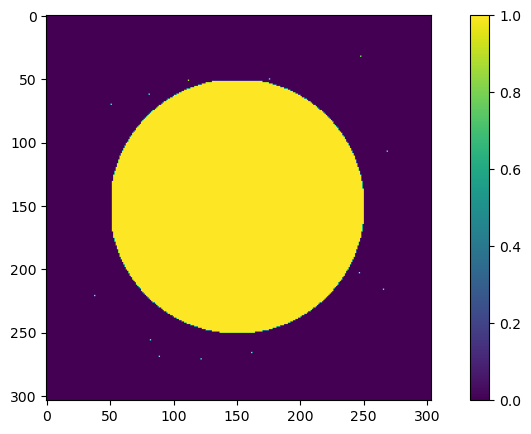

Percentage of pixels probed during one epoch: 51.650326282273575
Number of iterations required to probe full image: 2
The number of patches is  51
The number of iterations (batches) required to probe the whole image is  3
tensor(1.)


(304, 304, 50) (240, 240, 50) (304, 304)


In [ ]:
%matplotlib inline

num_iterations = 100
distribution_type = 'uniform'
std_dev = int(vol.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16

mask = np.copy(np.sum(vol,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(vol)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, vol.shape, mask.shape)

plt.figure(1);plt.clf()
plt.imshow(mask)
plt.colorbar()
plt.show()

npix = np.sum(mask)
pcr_probed = 100* (patch_size*patch_size*num_patches)/npix
print(f"Percentage of pixels probed during one epoch: {pcr_probed}")
niters_required = int(np.ceil(100/pcr_probed))
print(f"Number of iterations required to probe full image: {niters_required}")

mask_t = torch.tensor(mask, dtype=torch.bool, device=device)

indices = filter_patch_indices(torch.tensor(mask), patch_size)
print('The number of patches is ', len(indices))
print('The number of iterations (batches) required to probe the whole image is ', int(len(indices)/num_patches) )

counter = initialize_counter(rows, cols)
patch_dimensions = (patch_size, patch_size)
update_counter(counter, indices, patch_dimensions)
print(counter.max())
counter = counter.numpy()

plt.figure(2);plt.clf()
plt.imshow(counter + mask)
plt.colorbar()
plt.show()

## 🧠 Define PeakFitCNN Architecture and Initial Parameter Model

This section defines the neural network components used in the PeakFitCNN pipeline.

### 📐 `PeakFitCNN` Class

The `PeakFitCNN` class implements a **self-supervised upsampling CNN** that takes a spatially downsampled hyperspectral input (e.g., 4× smaller) and predicts full-resolution maps of peak parameters. It supports configurable normalization (instance, batch, or layer norm), bilinear upsampling, and optional final activation (e.g., ReLU or Sigmoid).

- The input is typically the downscaled hyperspectral imaging data or a low-resolution estimate or feature map.
- The output is a stack of parameter maps (e.g., amplitude, center, width, background).
- The network upsamples via two stages (2× + 2× for a total 4×).

### 🧩 `PrmCNN2D` Class

The `PrmCNN2D` class provides a modular structure for representing the initial parameter maps:
- If `prms_layer=True`, it holds a set of **trainable parameter tensors**, e.g. initialized to zeros or random values.
- If `cnn_layer=True`, a CNN is applied to either:
  - the initialized parameters, or
  - a provided input volume.

This module can operate in **three modes**:
1. Parameter map only (`prms_layer=True`, `cnn_layer=False`) — conventional approach.
2. CNN only (`prms_layer=False`, `cnn_layer=True`) — fully learned from input.
3. Combined (`prms_layer=True`, `cnn_layer=True`) — trainable initial maps refined via CNN layers.

---

### 🔢 Configuration and Parameter Count

We define:
- A single Gaussian peak per spectrum (`num_peaks = 1`)
- 3 peak parameters (area, position, width)
- 2 background parameters (slope, intercept)
- `total_params = 5`

We instantiate the `PrmCNN2D` model in **parameter-map-only mode**, initialized to zero. This setup corresponds to the **conventional voxel-wise fitting approach**, where each parameter is independently stored as a learnable 2D map.

The total number of trainable parameters is printed for comparison with the full resolution grid size.

In [ ]:

class PeakFitCNN(nn.Module):
    
    def __init__(self, nch_in=1, nch_out=1, nfilts=32, upscale_factor = 4,
                 norm_type='instance', activation='Linear', padding='same', npix=None):
        super(PeakFitCNN, self).__init__()

        self.npix = npix
        self.upscale_factor = upscale_factor
        # Initial feature extraction
        self.input = nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding, bias=True)

        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
        layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
        # Add normalization based on norm_type
        if norm_type == "instance":
            layers.append(nn.InstanceNorm2d(nfilts, affine=True))
        elif norm_type == "batch":
            layers.append(nn.BatchNorm2d(nfilts))
        elif norm_type == "layer":
            layers.append(nn.LayerNorm([nfilts, 2*self.npix, 2*self.npix]))

        # Add activation function
        layers.append(nn.ReLU(inplace=True))

        self.upsample1 = nn.Sequential(*layers)

        if self.upscale_factor == 4:
            layers = []
            layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
            layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
            # Add normalization based on norm_type
            if norm_type == "instance":
                layers.append(nn.InstanceNorm2d(nfilts, affine=True))
            elif norm_type == "batch":
                layers.append(nn.BatchNorm2d(nfilts))
            elif norm_type == "layer":
                layers.append(nn.LayerNorm([nfilts, 4*self.npix, 4*self.npix]))
            # Add activation function
            layers.append(nn.ReLU(inplace=True))

            self.upsample2 = nn.Sequential(*layers)

        # Final output layer
        self.xrdct = nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding, bias=True)

        # Final activation
        self.final_activation = None
        if activation == "ReLU":
            self.final_activation = nn.ReLU()
        elif activation == "Sigmoid":
            self.final_activation = nn.Sigmoid()
        elif activation == "LeakyReLU":
            self.final_activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):  # Feature maps from autoencoder2D are passed

        x = self.input(x)

        # Upsampling 1
        x = self.upsample1(x)

        if self.upscale_factor == 4:
            # Upsampling 2
            x = self.upsample2(x)

        # Output layer
        x = self.xrdct(x)

        if self.final_activation is not None:
            x = self.final_activation(x)

        return x
    
class PrmCNN2D(nn.Module):
    def __init__(self, npix, nch_in=1, nch_out=1, nfilts=32, nlayers=4, norm_type='layer', 
                 prms_layer=True, cnn_layer=True, tensor_vals = 'random', tensor_initial = None,
                 padding='same'):
        super(PrmCNN2D, self).__init__()
        self.npix = npix
        self.prms_layer = prms_layer
        self.cnn_layer = cnn_layer

        if self.prms_layer:
            if tensor_vals == 'random':
                self.initial_tensor = nn.Parameter(2*torch.randn(1, nch_in, npix, npix)-1)
            elif tensor_vals == 'zeros':
                self.initial_tensor = nn.Parameter(torch.zeros(1, nch_in, npix, npix))
            elif tensor_vals == 'ones':
                self.initial_tensor = nn.Parameter(torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'mean':
                self.initial_tensor = nn.Parameter(0.5*torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'random_positive':
                self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
            elif tensor_vals == 'custom':
                try:
                    self.initial_tensor = nn.Parameter(tensor_initial)
                except:
                    print('Custom tensor not provided. Using random tensor instead')
                    self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
        if self.cnn_layer:
            layers = []
            layers.append(nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding))  # 'same' padding in PyTorch is usually done by manually specifying the padding
            if norm_type=='layer':
                if padding=='valid':
                    layers.append(nn.LayerNorm([nfilts, self.npix -2, self.npix -2]))
                else:
                    layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
            elif norm_type=='instance':
                layers.append(nn.InstanceNorm2d(nfilts, affine = True))
            elif norm_type=='batchnorm':            
                layers.append(nn.BatchNorm2d(nfilts))

            layers.append(nn.ReLU())

            for layer in range(nlayers):
                
                layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding))
                if norm_type=='layer':
                    if padding=='valid':
                        layers.append(nn.LayerNorm([nfilts, self.npix -2*(layer + 2), self.npix -2*(layer + 2)]))
                    else:
                        layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
                elif norm_type=='instance':
                    layers.append(nn.InstanceNorm2d(nfilts, affine = True))            
                elif norm_type=='batchnorm':            
                    layers.append(nn.BatchNorm2d(nfilts))

                layers.append(nn.ReLU())

            layers.append(nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding))
            layers.append(nn.Sigmoid())
            self.cnn2d = nn.Sequential(*layers)

    def forward(self, x):
        if self.prms_layer and self.cnn_layer:
            out = self.cnn2d(torch.sigmoid(self.initial_tensor))
        elif self.cnn_layer and not self.prms_layer:
            out = self.cnn2d(x)
        elif self.prms_layer and not self.cnn_layer:
            out = torch.sigmoid(self.initial_tensor)
        return out
    

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None', prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)


Total number of parameters: 462080
Conventional number of parameters: 462080


## 🧪 Train PeakFitCNN in a Self-Supervised Manner

We now train the `PeakFitCNN` model using a **self-supervised learning strategy** based on physical reconstruction of the spectra. The CNN is optimized to predict normalized peak parameter maps, from which we reconstruct the full hyperspectral volume and compare it directly to the observed data (`volp`).

### 🧱 Model Components

- **Gaussian model**: The `gaussian()` function defines the parametric form of the peak used for spectral reconstruction.
- **Normalization bounds**: We define `param_min` and `param_max` dictionaries that set the physical limits for each parameter type (Area, Position, FWHM, Slope, Intercept). These are used to scale network outputs to valid physical ranges.
- **Loss function**: Mean Absolute Error (L1 loss) is used as the reconstruction loss. Additional metrics (MSE, RMSE) are also tracked for monitoring.
- **Input image**: We create a single-channel static image from the sum of all spectral channels, normalized and reshaped appropriately for the CNN input.

### 🔁 Training Loop

The model is trained over multiple epochs using the following loop:
1. The CNN produces a set of normalized parameter maps (`yc`) from the static image input.
2. These maps are locally filtered and then **clamped** using a ±20% soft constraint (`prf`) to stabilize training.
3. Parameters are denormalized and used to reconstruct each spectrum voxel-by-voxel:
   - Gaussian peaks are added for each voxel using predicted amplitude, position, and width.
   - Linear background is then added using predicted slope and intercept.
4. The reconstructed spectra are compared to the ground truth data (`volp`) for randomly sampled patches.
5. Loss is computed using RMSE and gradients are backpropagated to update model parameters.

A learning rate scheduler reduces the step size upon plateauing, and early stopping is triggered if the minimum learning rate is reached.

### 🕒 Training Time & Convergence

This block tracks:
- Total training time
- Number of epochs until convergence
- Final MAE, MSE, RMSE
- A loss log (`logloss`) for plotting learning curves later

This setup enables **self-supervised training of peak parameters** without any labelled supervision — the only objective is to minimize the difference between the observed and reconstructed spectra.

In [ ]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()


### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

with torch.no_grad():
    yprms = model(im_static)
    yprms = F.interpolate(yprms, scale_factor=1/4, mode='bilinear', align_corners=False)


epochs = 50000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model(im_static)
        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)

        lower_bound = filtered * (1 - prf)
        upper_bound = filtered * (1 + prf)

        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)
        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)   
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

4


  0%|          | 3/50000 [00:00<32:21, 25.75it/s]

MAE =  tensor(0.5680, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.4361, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6604, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6290808


  0%|          | 54/50000 [00:01<28:00, 29.72it/s]

MAE =  tensor(0.0259, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0336, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037308667


  0%|          | 106/50000 [00:03<26:43, 31.12it/s]

MAE =  tensor(0.0194, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0292, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.033972315


  0%|          | 155/50000 [00:05<29:33, 28.10it/s]

MAE =  tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0284, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.033326816


  0%|          | 207/50000 [00:06<27:20, 30.35it/s]

MAE =  tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0281, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.033053983


  1%|          | 254/50000 [00:08<27:21, 30.31it/s]

MAE =  tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0279, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03291963


  1%|          | 304/50000 [00:10<27:42, 29.90it/s]

MAE =  tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0278, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032860585


  1%|          | 354/50000 [00:11<27:35, 29.99it/s]

MAE =  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0278, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032807373


  1%|          | 404/50000 [00:13<28:08, 29.37it/s]

MAE =  tensor(0.0148, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0278, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03278919


  1%|          | 455/50000 [00:15<27:38, 29.87it/s]

MAE =  tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032747142


  1%|          | 506/50000 [00:17<28:57, 28.48it/s]

MAE =  tensor(0.0144, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0277, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03275011


  1%|          | 555/50000 [00:18<27:36, 29.85it/s]

MAE =  tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0277, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032740124


  1%|          | 606/50000 [00:20<26:44, 30.78it/s]

MAE =  tensor(0.0142, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032724135


  1%|▏         | 654/50000 [00:21<26:16, 31.30it/s]

MAE =  tensor(0.0141, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032720834


  1%|▏         | 704/50000 [00:23<28:14, 29.10it/s]

MAE =  tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03270291


  2%|▏         | 757/50000 [00:25<27:22, 29.98it/s]

MAE =  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032687318


  2%|▏         | 807/50000 [00:27<27:24, 29.92it/s]

MAE =  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032702297


  2%|▏         | 856/50000 [00:28<26:42, 30.67it/s]

MAE =  tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032686163


  2%|▏         | 904/50000 [00:30<26:32, 30.84it/s]

MAE =  tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032683503


  2%|▏         | 954/50000 [00:31<28:39, 28.52it/s]

MAE =  tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032671392


  2%|▏         | 1006/50000 [00:33<30:47, 26.52it/s]

MAE =  tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.032689303


  2%|▏         | 1054/50000 [00:35<32:49, 24.86it/s]

MAE =  tensor(0.0136, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0326683


  2%|▏         | 1091/50000 [00:37<28:27, 28.65it/s]

Epoch 01086: reducing learning rate of group 0 to 5.0000e-02.


  2%|▏         | 1107/50000 [00:37<27:54, 29.19it/s]

MAE =  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0270, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03219052


  2%|▏         | 1109/50000 [00:37<27:43, 29.39it/s]


KeyboardInterrupt: 

## 📊 Visualize Training Loss and CNN-Predicted Parameter Maps

In this final section, we evaluate the performance of the trained PeakFitCNN model by visualizing both the training history and the reconstructed peak parameter maps.

### 📉 Loss Curve

We first plot the logged RMSE loss (`logloss`) across training epochs (starting from epoch 100 for clarity). This helps verify whether the model has converged and how stable the optimization process was.

### 🗺️ Extract Predicted Parameters from CNN

After training, we extract the output from the model:
- The raw predicted maps are optionally smoothed using a `3×3` average filter.
- Each parameter map (area, position, FWHM, slope, intercept) is **denormalized** to recover physical units.
- The output maps are spatially cropped to remove padding (based on the difference in shape between predicted and ground truth volumes).

### 🎯 Masked Comparison and Visual Output

To compare the CNN results with the ground truth:
- A mask is applied to focus only on the regions where meaningful signal exists (i.e., where `peak_area > 0.1`).
- The CNN-predicted maps are **concatenated side-by-side** with the corresponding ground truth maps for visual inspection.

This comparison is done for all five parameters:
1. **Peak Area**
2. **Peak Position**
3. **Peak FWHM**
4. **Background Slope**
5. **Background Intercept**

Each parameter is shown as a 2D image, where the **left half** corresponds to the ground truth and the **right half** shows the PeakFitCNN prediction (masked to remove background).

These visualizations help assess both spatial fidelity and denoising performance of the CNN-based peak fitting approach.

(304, 304) (304, 304) (304, 304) (304, 304) (304, 304)
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)
52
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)


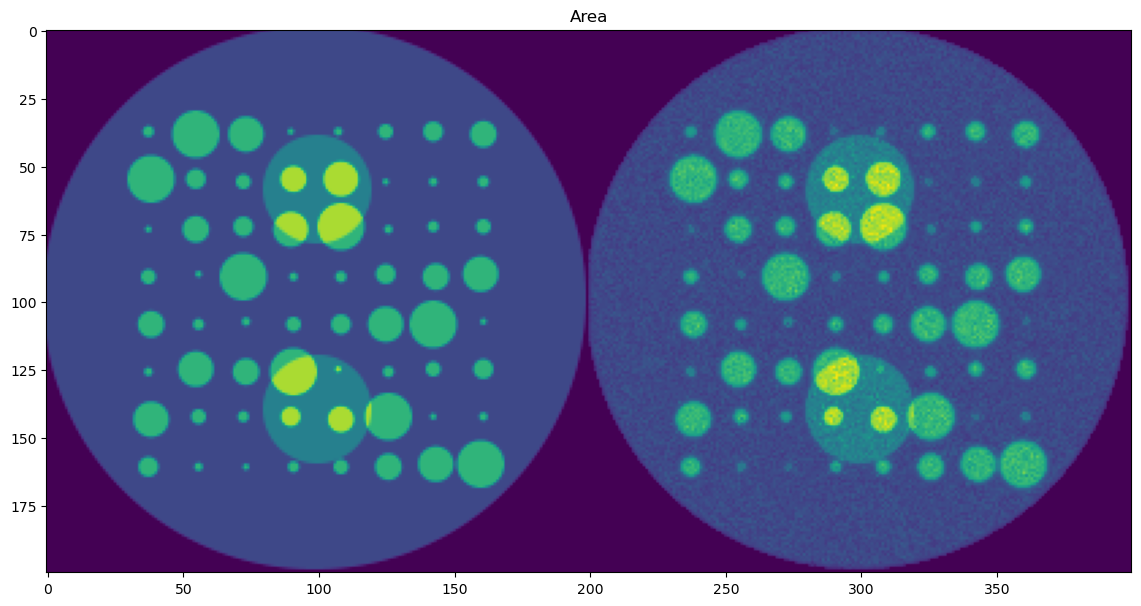

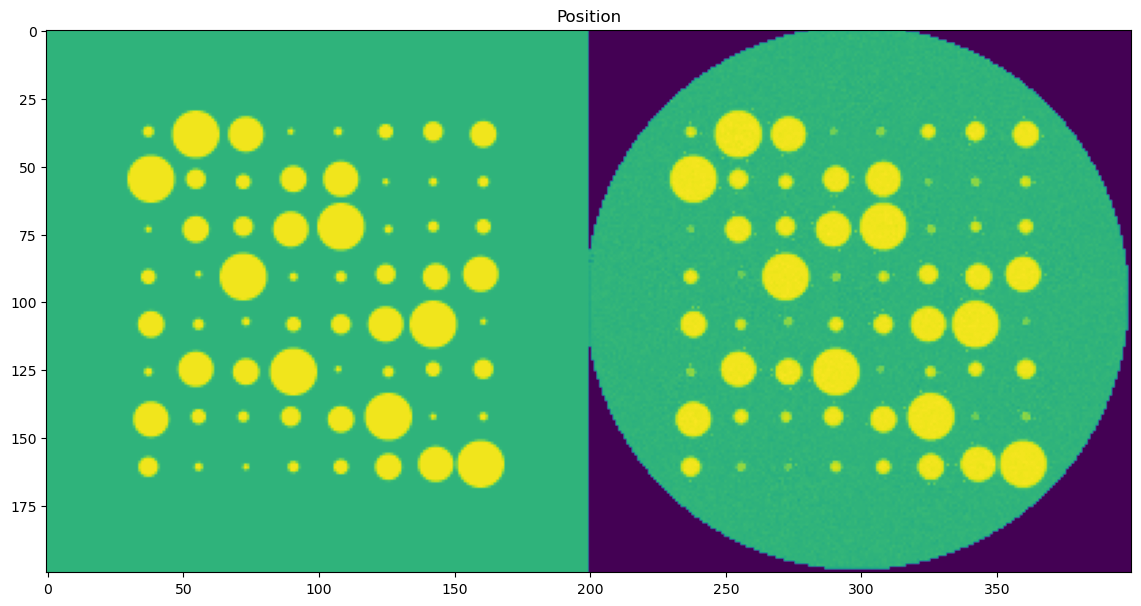

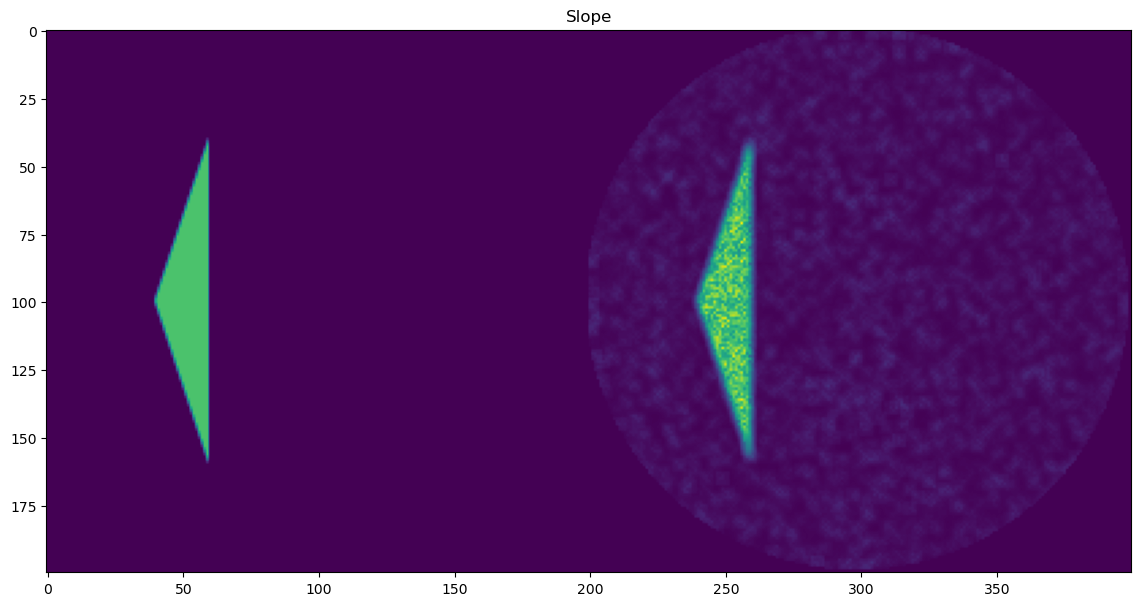

In [ ]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('prms_only')
plt.show()

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()



## 🧠 Define and Prepare PeakFitCNN for Self-Supervised Training from Downsampled Input

We now instantiate the **PeakFitCNN model** that performs self-supervised peak fitting directly from **4× downsampled hyperspectral data**. This model is designed to replace the parameter map initialization used earlier with a CNN that learns the full-resolution parameter maps from a coarse input.

### 🏗️ Model Configuration

- `nch_in`: Number of input spectral channels (i.e., length of diffraction axis)
- `nch_out`: Number of predicted parameter maps (total of 5)
- `nfilts`: Number of filters in each layer; here set to match the number of input channels
- `upscale_factor`: 4× spatial upsampling to recover full-resolution output
- `norm_type`: Instance normalization for stability
- `activation`: Sigmoid activation ensures output values are bounded in [0, 1]

The total number of trainable parameters in the CNN is printed and compared against the number of parameters used in the **conventional approach**, which stores a separate value per parameter per voxel.

### 🔄 Prepare Inputs for CNN

We convert the original noisy 3D hyperspectral volume (`volp`) into a 4D tensor and **spatially downsample it** by a factor of 4 using bilinear interpolation. This downsampled input will be fed to the CNN to predict the full-resolution parameter maps.

This approach allows the model to:
- Exploit spatial context via convolution
- Combine denoising, peak fitting, and resolution enhancement in a single learned model

The shapes of both full-resolution and downsampled tensors are printed for verification.

In [ ]:

model_cnn = PeakFitCNN(nch_in=volp.shape[2], nch_out=nch_out, nfilts=64,  upscale_factor = 4, norm_type='instance', 
              activation='Sigmoid', padding='same').to(device)
nch_in = volp.shape[2]
nfilts = volp.shape[2] # 2*total_params

# Calculate the total number of parameters
model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")

print('Number of filters:', nfilts)
print(nch_out, npix)

print("Conventional number of parameters:", npix*npix*total_params)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)
downsampled = F.interpolate(yobs, scale_factor=1/4, mode='bilinear', align_corners=False)

print(downsampled.shape, yobs.shape, yobs.shape[2]/4)

Total number of parameters: 7427653
Number of filters: 50
5 304
Conventional number of parameters: 462080
torch.Size([1, 50, 76, 76]) torch.Size([1, 50, 304, 304]) 76.0


## 🔁 Train PeakFitCNN from Downsampled Hyperspectral Input

We now train the **PeakFitCNN model** using the 4× downsampled hyperspectral input volume. This deep-learning approach replaces explicit parameter map initialization with a CNN trained end-to-end to predict all peak parameters.

The training follows the same **self-supervised spectral reconstruction strategy** as before, but now the input is downsampled data and the model itself performs both super-resolution and peak fitting.

### ⚙️ Training Configuration

- `epochs = 50000`: maximum number of training epochs
- `prf = 0.2`: ±20% soft constraint around local average predictions to stabilize training
- `patience = 200`: used by the learning rate scheduler to detect plateaus
- `optimizer`: Adam with an initial learning rate of `0.001`
- `scheduler`: learning rate is halved on plateaus, down to a minimum of `1e-5`
- `num_patches`: number of spatial patches processed per batch

### 🧠 Training Loop

For each epoch:
1. A forward pass is performed using the downsampled hyperspectral data as input.
2. The CNN predicts full-resolution normalized parameter maps (`yc`).
3. A local average filter is applied, and values are **clamped within ±20%** of the smoothed estimates.
4. Spectral reconstruction is done using the same Gaussian + linear background model.
5. Random patches of the predicted and ground truth spectra are extracted.
6. The **RMSE loss** is computed between predicted and true spectra, and used for backpropagation.

The loop continues until convergence or the minimum learning rate is reached.

### 📈 Output

At the end of training, the code logs:
- Final **epoch count**
- Final **MAE, MSE, RMSE**
- Total **training time** in seconds
- A full log of the RMSE loss at each epoch (`logloss`), which can later be plotted to assess convergence

This completes the training of the second fitting approach, where **PeakFitCNN directly learns to denoise and fit peak parameters from low-resolution hyperspectral input**.

In [ ]:

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

prf = 0.2
epochs = 50000
patience = 200
learning_rate = 0.001
min_lr = 1E-5
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr, verbose=1)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model_cnn(downsampled)

        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
        lower_bound = filtered * (1.0 - prf)
        upper_bound = filtered * (1.0 + prf)
        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False) 
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

4


  0%|          | 2/50000 [00:01<11:37:38,  1.19it/s]

MAE =  tensor(0.4362, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2930, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5413, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.61716825


  0%|          | 52/50000 [00:09<2:10:37,  6.37it/s]

MAE =  tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0386, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.043860126


  0%|          | 53/50000 [00:10<2:39:58,  5.20it/s]


KeyboardInterrupt: 

## 🧪 Compare Parameter Maps from PeakFitCNN and Conventional Approach

After training the PeakFitCNN model on downsampled input, we now extract and visualize the predicted parameter maps. This section mirrors the post-processing used earlier for the conventional parameter maps, allowing for direct visual comparison.

### 📉 Loss Curve

We first plot the RMSE loss curve from the PeakFitCNN training (`logloss`), starting from epoch 100. This helps assess whether the model has converged and how its behavior compares to the conventional approach.

### 🗺️ Extract CNN-Predicted Parameters

We:
- Perform a forward pass through the trained PeakFitCNN using the downsampled input
- Apply local smoothing (`3×3` average pooling)
- Clamp predictions within ±20% of the smoothed values
- Denormalize all five parameter maps: area, position, FWHM, slope, and intercept

As before, we crop the output to remove padding (`ofs`) and apply a binary mask (`msk`) to focus only on relevant signal regions.

### 🔍 Side-by-Side Comparison

For each parameter, we concatenate the following maps side-by-side:
1. **Ground truth** from the simulation
2. **Conventional parameter map** (fit via `PrmCNN2D`)
3. **CNN prediction** (from PeakFitCNN)

These are visualized with `imshow()` using the `'jet'` colormap to highlight spatial gradients.

This comparison allows us to qualitatively assess:
- Fidelity to the true parameter maps
- Degree of denoising
- Spatial continuity and sharpness

52
(200, 200) (200, 200) (200, 200)


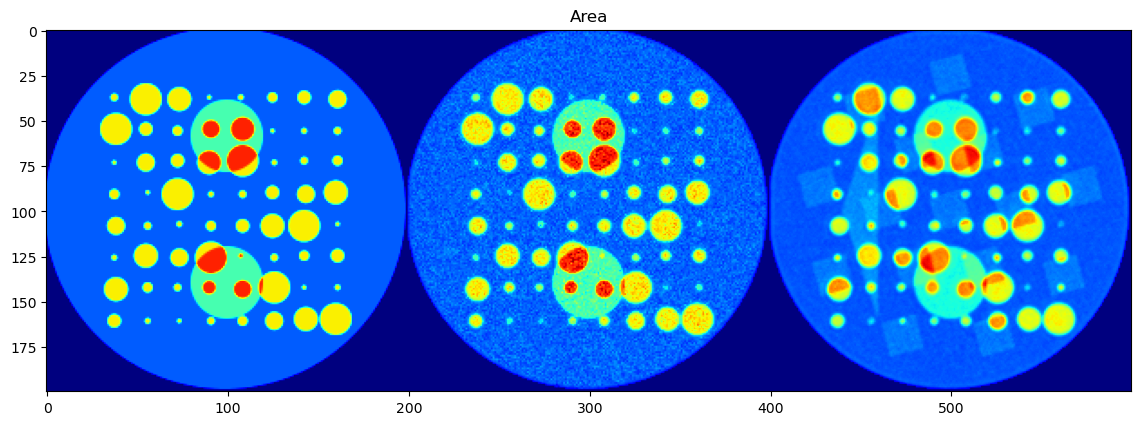

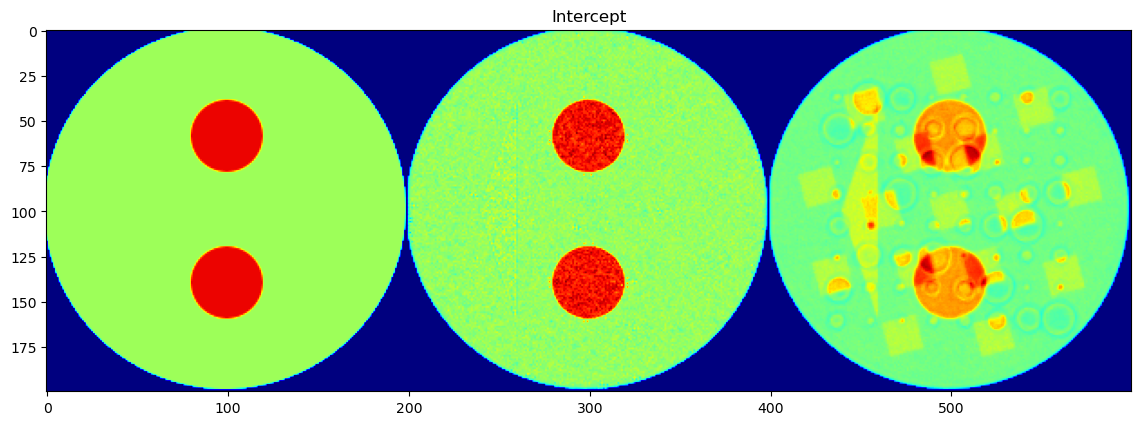

In [ ]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('cnn')
plt.show()

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

print(peak_area.shape, prms_peak1_area.shape, cnn_peak1_area.shape)

areac = np.concatenate((peak_area*msk, prms_peak1_area*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, prms_peak1_pos*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, prms_peak1_fwhm*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, prms_slope*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, prms_intercept*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac, cmap = 'jet')
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc, cmap = 'jet')
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc, cmap = 'jet')
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec, cmap = 'jet')
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc, cmap = 'jet')
# plt.colorbar()
plt.title('Intercept')
plt.show()


## ✅ Summary and Final Remarks

In this notebook, we compared two distinct strategies for hyperspectral peak fitting in synthetic XRD-CT datasets:

### 📌 Conventional Approach
- Uses explicit, per-parameter 2D maps to define each peak and background component.
- These parameter maps are trained directly to minimize spectral reconstruction error.
- While effective, this approach does not leverage spatial or spectral context beyond local filtering.

### 📌 PeakFitCNN (Self-Supervised CNN)
- Uses a downsampled hyperspectral input and learns to output **full-resolution, denoised parameter maps**.
- Trained using a **self-supervised loss** based on spectral reconstruction, requiring no labelled parameter maps.
- Combines denoising, resolution enhancement, and peak decomposition in a single, end-to-end architecture.

### 🧪 Results and Observations
- **Both methods successfully reconstructed the peak parameters**, even in the presence of Poisson noise.
- **PeakFitCNN showed improved spatial coherence**, and slightly lower noise levels in the parameter maps.
- The CNN was also able to generalize from lower-resolution inputs, demonstrating its potential for **super-resolution peak fitting** in real experimental contexts.

### 📈 Future Directions
- Extend to **multi-peak** or **asymmetric peak** fitting models (e.g. Pseudo-Voigt).
- Train PeakFitCNN on **experimental data** using self-supervised or semi-supervised frameworks.
- Integrate physical priors or constraints (e.g. non-negativity, continuity) directly into the CNN architecture.


This approach demonstrates the feasibility of combining physical modelling with modern deep learning techniques to enhance chemical imaging workflows in XRD-CT and beyond.